# MAP 568 Project

Maxime Vincent & Swann Chelly

In [10]:
import numpy as np

from constant import *
from scipy import *
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
import plotly as po
from progressbar import ProgressBar
import matplotlib.pyplot as plt

## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [86]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps,variables, constants):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    #temps = round(temps,1)
    #if temps == 50:
    #    temps = 50.1
    #elif temps > 100.:
    #    temps = 100.
    #i = time.index(temps)
    
    if type(variables)!= dict:
        variables = dict(zip(variables_keys,variables))
        constants = dict(zip(constants_keys, constants))
    else : 
        variables = variables
        constants = constants
    
    
    tau = constants['tau_0']*np.exp(-variables['mu']*max(temps-variables['N'],0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_moins
    DI_plus = variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_plus
    DR_moins = constants['gamma_IR']*I_moins
    DR_plus_I = constants['gamma_IR']*I_plus
    DH = constants['gamma_IH']*(I_moins + I_plus)-(constants['gamma_HR']+constants['gamma_HD']+constants['gamma_HU'])*H
    DU = constants['gamma_IU']*(I_moins + I_plus)+constants['gamma_HU']*H-(constants['gamma_UR'] + constants['gamma_UD'])*U
    DR_plus_H = constants['gamma_HR']*H+constants['gamma_UR']*U
    DD =constants['gamma_UD']*U+constants['gamma_HD']*H  
    DD_R = (variables['lambda_1']+constants['gamma_IH']+constants['gamma_IU'])*I_moins-D_R
    
    
    return(DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R)


Text(0, 0.5, 'Nombre de personne en réanimation')

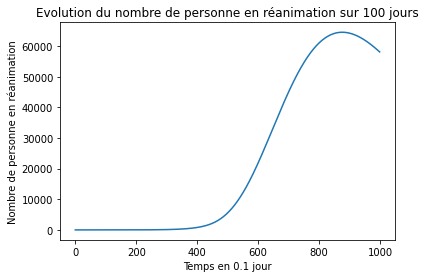

In [87]:
# Analyse des résultats

variables = init_variables()
constants = compute_constants(variables)

syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
plt.plot(simulation[:,6])
plt.title(f"Evolution du nombre de personne en réanimation sur {global_constants['T_MAX']} jours")
plt.xlabel(f"Temps en {global_constants['deltaT']} jour")
plt.ylabel("Nombre de personne en réanimation")



2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [13]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 

M = 10000

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur {M} simulations")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        variables = init_variables(deltaT=0.1,global_constants = global_constants)
        constants = compute_constants(variables)
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))      
        peak_value.append(np.max(simulation[:,6]))
        peak_day.append(int(np.argmax(list(simulation[:,6]))*global_constants['deltaT']))
        pos.append(np.max(simulation[:,1]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)


Echantillonnage de Monte Carlo sur 10000 simulations


KeyboardInterrupt: 

La valeur moyenne du pic est de 32371.51 et appartient à l'intervalle de confiance à 95% suivant : [31006.24,33736.77] 
 Le quantile à 10% du pic de réanimation est : 40.69476399255217
 Le quantile à 90% du pic de réanimation est : 108214.93671980893


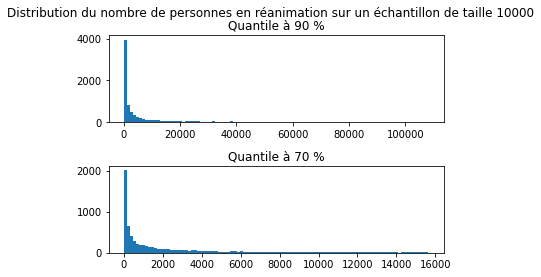

In [17]:
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 


fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if value < q_70], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

En supposant que la distribution du nombre de cas en réanimation au pic de l'épidémie suis une loie exponentielle, nous pouvons donner son paramètre $\lambda = \frac{1}{\mathbb{\hat{E}}(X)}$ où $X$ correspond à la variable aléatoire liée au nombre de cas en réanimation au pic de l'épidémie. Nous la notrons ici `lbd`.


3.089136153710618e-05


(array([30733.47001043, 27085.25234732, 26053.43321028, 24947.91270631,
        21483.94846053, 19125.50471872, 18204.23763208, 16582.80755958,
        16435.40482572, 14629.7213359 , 13450.499465  , 12787.18716261,
        10686.69820507, 10428.74342081,  9691.72975149,  8033.44899553,
         6743.67507423,  6817.37644116,  6117.21345531,  5564.45320333,
         5417.05046946,  5343.34910253,  4606.33543322,  3648.21766311,
         3500.81492925,  4237.82859856,  2800.6519434 ,  2653.24920953,
         2579.5478426 ,  2284.74237488,  2321.59305834,  1842.53417329,
         1474.02733863,  1695.13143942,  1547.72870556,  1289.7739213 ,
         1437.17665516,  1142.37118744,   737.01366931,  1142.37118744,
         1252.92323784,   810.71503625,   994.96845358,   589.61093545,
          479.05888505,   368.50683466,   257.95478426,   552.76025199,
          479.05888505,   331.65615119,   368.50683466,   294.80546773,
          515.90956852,   221.10410079,   294.80546773,   331.65

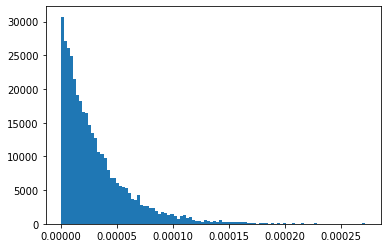

In [18]:
lbd = 1/mean_value
print(lbd)
Y = np.random.exponential(lbd,10000)
plt.hist(Y,bins = 100,density = True)

La valeur moyenne du pic est de 68.08 et appartient à l'intervalle de confiance à 95% suivant : [67.77,68.39] 
 Le quantile à 10% du pic de réanimation est : 48.0
 Le quantile à 90% du pic de réanimation est : 92.0


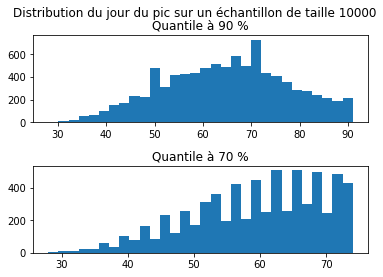

In [19]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 30)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if day < q_70_day], bins = 30)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

# Analyse de sensibilité qualitative : Criblage

In [8]:
def Morris(R,eps):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    R : int, 
        Taille de l'échantillon.
    eps : float,
        paramètre pour évaluer nos différences finies (f(x+eps)-f(x))/eps
    
    Sorties : 
    ---------
    moyenne_grad_peak_value  : array,
        Moyenne du gradient du nombre réanimation au pic de l'épidémie pour chaque simulation.
    moyenne_grad_peak_day    : array, 
        Moyenne du gradient du Jour du pic pour chaque simulation.
    sigma_grad_peak_value  : array,
        Ecart-type du gradient du nombre réanimation au pic de l'épidémie pour chaque simulation.
    sigma_Moyenne_grad_peak_day    : array, 
        Ecart-type du gradient du Jour du pic pour chaque simulation.
    
    """
    
    print(f"Calcul de sensibilité")
    grad_peak_value,grad_peak_day = [],[]
    pbar = ProgressBar()
    for i in pbar(range(R)):
        variables = init_variables()
        constants = compute_constants(variables)
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation_ref=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
        peak_value_ref = np.max(simulation_ref[:,6])
        peak_day_ref = int(np.argmax(list(simulation_ref[:,6]))*global_constants['deltaT'])
        d_peak_value, d_peak_day = [], []
    
        for key, value in variables.items():
            sauvegarde = variables[key]
            variables[key] = sauvegarde +eps
            constants = compute_constants(variables)
            simulation= odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
            peak_value = np.max(simulation[:,6])
            peak_day = int(np.argmax(list(simulation[:,6]))*global_constants['deltaT'])
            d_peak_value.append((peak_value-peak_value_ref)/eps)
            d_peak_day.append((peak_day-peak_day_ref)/eps)
            variables[key] = sauvegarde
        
        grad_peak_value += [d_peak_value]
        grad_peak_day += [d_peak_day]
        
    grad_peak_value, grad_peak_day = np.abs(np.array(grad_peak_value)), np.abs(np.array(grad_peak_day))
     
    moyenne_grad_peak_value = np.mean(grad_peak_value, axis=0)
    moyenne_grad_peak_day = np.mean(grad_peak_day, axis=0)
    sigma_grad_peak_value = np.sqrt(np.var(grad_peak_value, axis=0))
    sigma_grad_peak_day = np.sqrt(np.var(grad_peak_day, axis=0))
    
    return( moyenne_grad_peak_value,  moyenne_grad_peak_day, sigma_grad_peak_value, sigma_grad_peak_day )
        

R=100
eps = 10**(-4)
moyenne_grad_peak_value,  moyenne_grad_peak_day, sigma_grad_peak_value, sigma_grad_peak_day = Morris(R, eps)

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Calcul de sensibilité


100% (100 of 100) |######################| Elapsed Time: 0:00:29 Time:  0:00:29


In [9]:
print(moyenne_grad_peak_value)
print(moyenne_grad_peak_day)
print(sigma_grad_peak_value)
print(sigma_grad_peak_day)

[4.19905680e+04 6.54428652e+04 5.62246061e+05 2.14991970e-01
 5.12549068e+04 2.64866143e-02 4.63938045e+04 1.26875692e+06
 7.91285798e+05 3.52350880e+03 1.76222658e+03 1.06202455e+04
 2.08075196e+02 9.26004823e+02 0.00000000e+00]
[  0.   0. 200.   0.   0.   0.   0. 600.   0.   0.   0.   0.   0.   0.
   0.]
[1.15120797e+05 2.09462609e+05 1.65119525e+06 1.55317518e+00
 1.70041629e+05 1.76690051e-01 1.13022113e+05 4.06201464e+06
 1.92083228e+06 8.82828310e+03 4.41479737e+03 2.73288989e+04
 7.42636394e+02 2.66952741e+03 0.00000000e+00]
[   0.            0.         1400.            0.            0.
    0.            0.         2374.86841741    0.            0.
    0.            0.            0.            0.            0.        ]


#### analyse des résultats : ...

## Criblage avec SALib

In [37]:
from SALib.analyze import morris
from SALib.sample import morris as sample_morris

In [38]:
problem = {
    'num_vars': 15,
    'names': ['p_a','p_IH','p_IU','p_HD','p_HU','p_UD','R_0','mu','lambda_1','t_0','N','N_I','N_H','N_U','I_moins_0'],
    'bounds': [[0.4,0.9],[0.05,0.2],[0.01,0.04],[0.1,0.2],[0.1,0.2],[0.2,0.4],[2.9,3.4],[0.01,0.08],[10**(-4),10**(-3)],[0,30],[30,50],
[8,12],[15,25],[10,20],[1,100]]
}


def Resolution(parametres):
    peak_value = np.zeros(len(parametres))
    peak_day = np.zeros(len(parametres))
    
    for i, X in enumerate(parametres):
    
        if type(X)!= dict:
            variables = dict(zip(variables_keys,X))
            #constants = dict(zip(constants_keys, constants))
        else : 
            variables = X
        constants = compute_constants(variables)   
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        solution=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
        peak_value[i]=np.max(solution[:,6])
        peak_day[i]=int(np.argmax(list(simulation[:,6]))*global_constants['deltaT'])
    return(peak_value, peak_day)



In [39]:
X = sample_morris.sample(problem, 100, num_levels=4)
peak_value, peak_day = Resolution(X)
Smorris_value = morris.analyze(problem, X, peak_value, conf_level=0.95,print_to_console=True, num_levels=4)
Smorris_day = morris.analyze(problem, X2, peak_day, conf_level=0.95,print_to_console=True, num_levels=4)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
p_a                             59673.485 -59673.485       21012.742 116058.173
p_IH                            11420.656  11420.656        4715.032  28455.496
p_IU                            21361.295  21361.295        9051.091  49733.630
p_HD                                0.000      0.000           0.000      0.002
p_HU                             8538.400   8538.400        5344.272  27057.314
p_UD                                0.000      0.000           0.000      0.001
R_0                             23782.282  23782.282       11258.930  56569.593
mu                              49810.551 -49810.551       22674.422 110893.147
lambda_1                          909.838    909.838         378.715   2235.118
t_0                             86275.465 -86275.465       34286.981 182527.360
N                               43498.420  43498.420       18139.615  93789.235
N_I                             40820.16

# Analyse de sensibilité quantitative : Sobol

In [32]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from pylab import *
from scipy.integrate import odeint

In [34]:
param_values = saltelli.sample(problem, 100, calc_second_order=True)
peak_value, peak_day = Resolution(param_values)
Si_peak_value = sobol.analyze(problem, peak_value, print_to_console=True)
Si_peak_day = sobol.analyze(problem, peak_day, print_to_console=True)

Group S1 S1_conf ST ST_conf
p_a -0.000146 0.020678 0.037221 0.065862
p_IH -0.002007 0.005740 0.002609 0.004675
p_IU -0.003144 0.015213 0.018217 0.035263
p_HD -0.000000 0.000000 0.000000 0.000000
p_HU 0.000338 0.008289 0.005514 0.012261
p_UD 0.000000 0.000000 0.000000 0.000000
R_0 -0.013241 0.036366 0.056631 0.106677
mu 0.033912 0.147302 0.249991 0.440106
lambda_1 0.000033 0.000739 0.000046 0.000096
t_0 0.132375 0.135238 0.187887 0.300740
N 0.060586 0.123713 0.147749 0.295053
N_I 0.002764 0.031315 0.073431 0.143127
N_H 0.000368 0.002150 0.000425 0.000980
N_U 0.003004 0.007093 0.002511 0.004568
I_moins_0 0.001311 0.014525 0.011436 0.028778

Group_1 Group_2 S2 S2_conf
p_a p_IH 0.006083 0.032374
p_a p_IU 0.005729 0.032162
p_a p_HD 0.005829 0.033045
p_a p_HU 0.005058 0.034163
p_a p_UD 0.005829 0.033045
p_a R_0 0.006293 0.032547
p_a mu -0.008589 0.051503
p_a lambda_1 0.005835 0.033003
p_a t_0 -0.005270 0.030789
p_a N -0.003412 0.045203
p_a N_I 0.004408 0.034762
p_a N_H 0.005837 0.033007
p_a 

# Calibration

In [14]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import ticker

In [15]:

contamination = pd.read_csv('data_per_day.csv', sep = ';')
contamination.columns = [jour,'detecte']
contamination[jour] = pd.to_datetime(contamination[jour],infer_datetime_format = True)
contamination = contamination[contamination[jour]<= '2020-05-11']
contamination['detecte'] = contamination['detecte'].diff(periods = 1)

 
hosp          = pd.read_csv('donnees_hospitalieres.csv', ';')
hosp[jour]    = pd.to_datetime(hosp[jour])
hosp          = hosp.groupby(jour).agg('sum').reset_index(False)[[jour,'hosp','rea','rad','dc']]
big_table     = hosp.merge(contamination, left_on= jour, right_on = jour)
big_table     = big_table[big_table[jour]<= '2020-05-11']
big_table.head()   

,jour,hosp,rea,rad,dc,detecte
0,2020-03-18,5905,1535,1627,435,1404.0
1,2020-03-19,7961,1975,2322,642,1861.0
2,2020-03-20,10272,2564,3128,890,1617.0
3,2020-03-21,11599,2872,3580,1041,1847.0
4,2020-03-22,13675,3311,4188,1251,1559.0


Text(0.5, 1.0, 'Spread of the epidemic')

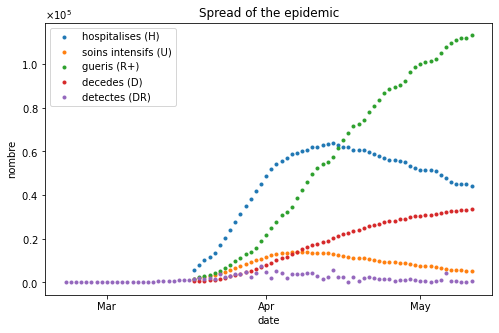

In [16]:
columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

# Calibration déterministe

Pour répondre à cette question, nous lançons la fonction `minimize` de scipy.optimize 100 fois et nous gardons uniquement le 15-uplets de valeurs qui minimise le plus fortement la fonction objectif.

Une telle démarche a nécessairement un coût de calcul assez fort et nous sauvons donc le tout dans un excel fournit avec le jupyter. Afin de pouvoir générer les variables veuillez mettre `generate_variables` à la valeur `True`. Autrement, les variables seront importées depuis le fichier CSV en question. 

In [17]:
from scipy.optimize import minimize
generate_variables = False

In [18]:
# Table pre-processing
contamination = contamination[('2020-02-25' <= contamination[jour])& (contamination[jour]<= '2020-03-31')]
big_table     = big_table[big_table[jour]<= '2020-03-31']
sigmas        = [1,1,1,1,1]


In [116]:

def Epsilon(variables,constants,contamination = contamination,big_table=big_table,global_constants=global_constants, sigmas = sigmas,n_DR=n_DR,n_H=n_H):
    """
    parameters will be a dictionnary similar to the one resulting from init_constant    
    """
    
    syst_CI=array([global_constants['S_0'],variables[-1],0,0,0,0,0,0,0,0])
    simulation=odeint(equa_diff,syst_CI,constants[-2],args = (variables,constants))[::10]
    
    DR = ((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1]))**2/sigmas[0]
    
    H  = ((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5]))**2/sigmas[1]
    U  = ((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6]))**2/sigmas[2]
    D  = ((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8]))**2/sigmas[3]
    R  = ((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7]))**2/sigmas[4]
    return np.sum(DR) + np.sum(H+U+D+R)



In [83]:


def q_7_function():
    """
    This function compute the minimization routine one time and return the 15-uplet and the value of the objectiv function.    
    """
    variables = init_variables(T_MAX = 66)
    constants = compute_constants(variables, global_constants = global_constants)
    variables = list(variables.values())
    constants = list(constants.values())

    res = minimize(Epsilon,x0 = variables,bounds = bound, args = (constants))
    optimal_variables = dict(zip(variables_keys,res.x))
    return optimal_variables,res.fun

if generate_variables :     
    all_results = []
    all_variables = []
    pbar = ProgressBar()

    for i in pbar(range(100)):
        optimal_variables, res = q_7_function()
        all_results.append(res)
        all_variables.append(optimal_variables)

    best_variables = all_variables[np.argmin(all_results)]
    with open('best_variables_q7.csv', 'w') as f:
        f.write("%s,%s\n"%('variables','values'))
        for key in best_variables.keys():
            f.write("%s,%s\n"%(key,best_variables[key]))
    
    
else : 
    best_variables = pd.read_csv('best_variables_q7.csv', ',')
    best_variables = best_variables['values'].to_numpy()
    best_variables = dict(zip(variables_keys,best_variables))
    

In [84]:

constants  = compute_constants(best_variables)
syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))[::10]

66


Text(0.5, 1.0, 'Spread of the epidemic')

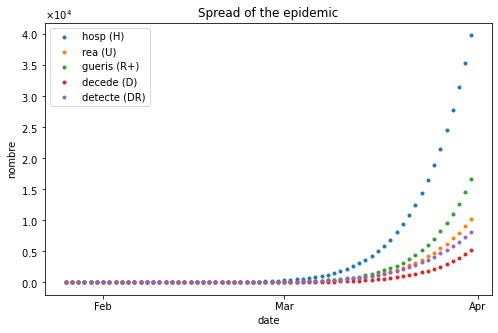

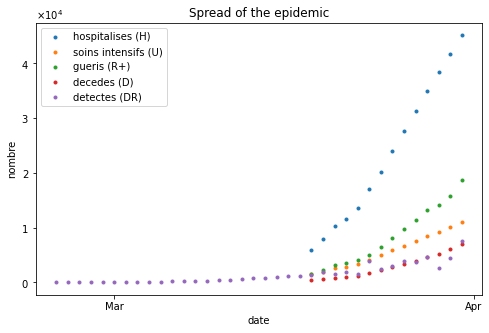

In [85]:
fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
columns  = [5,6,7,8,9]
titles   = {'5':'hosp (H)','6': 'rea (U)','8':'decede (D)', '9':'detecte (DR)','7': 'gueris (R+)'}
time     = pd.date_range(start =  '2020-01-26', end = '2020-03-31', freq = 'D')

print(len(simulation))
for i,col in enumerate(columns) : 
    axs.scatter(time,simulation[:66,col],marker = '.', label = titles[f"{col}"])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')



columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

8) **Donnez les valeurs de $\sigma_C$ pour $C$ dans $\{H,U,D,R\}$**

L'énoncé nous dit que : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{DR}^{-n_{DR}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$

Que l'on peut réécrire de la manière suivante afin de d'utiliser une optimisation sous log-vraisemblance par la suite : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$


On atteint un optimum pour l'expression suivante quand toutes les compostantes du gradient sont nulles. En raisonnant pour $\sigma_{DR}$ on a : 

$\begin{align}
\frac{\partial}{\sigma_{DR}}p(data|x,\sigma)&=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times(-\frac{n_{DR}}{\sigma_{DR}}+\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}})e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}\\
&=0
\end{align}$
Ce qui revient à écrire que : 


$\begin{align}
& \ \frac{n_{DR}}{\sigma_{DR}}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}}\\
\Leftrightarrow &  \ \sigma_{DR}^{2}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{n_{DR}}
\end{align}$

En raisonnant de même pour les autres sigmas, il vient que :

$\sigma_{C}^{2}=\sum_{i=1}^{n_{H}}\frac{f_{C}(x,s_{i})^{2}}{n_{H}}$



9) **Donner une expression implicite de la loi a posteriori $p(x|data)$ des paramètres x.**

Le théorème de Bayes nous donne que : $p(x|data) \propto p(data|x)p_0(x)$.

Pour l'approche plug-in, on fixe les valeurs de sigma tel que définis à la question 8. Dans ce cas, on a : 

$\begin{equation}
p(x|data)=p(data|x)p_0(x)
\end{equation}$

Dans le cadre de l'approche full-bayésienne comme on a : $\pi(\sigma_C)=(\sigma_C)^{-1}$ pour $C$ dans $\{H,U,D,R\}$ alors on peut écrire que : $\begin{align}
p(x|data) &\propto \int_{\sigma}p(x,\sigma|data)d\sigma\\
&\propto \int_{\sigma}p(data|x,\sigma)p(\sigma)p_0(x)d\sigma
\end{align}$

En utilisant les expressions de chacun des $\sigma$ on peut développer l'intégrale et donner une expression implicite de cette densité. 


10) **Dans le cas plug-in, puis dans le cas full-bayésien, comparer les lois a priori et a posteriori uni-dimensionnelles de chacun des paramètres (histogramme,moyenne, variance). Estimer la matrice de corrélation a posteriori des paramètres. Quels sont les paramètres pour lesquels l'incertitude a été fortement réduite ou au contraire très peu réduite ?**


Nous connaissons les lois à postériori à une constante multiplicative près. De ce fait nous souhaitons donc simuler la distribution de $p(x|data)$ en utilisant un algorithme de Metropolis Hasting. 

A partir d'un point $X_0$, nous construisons la chaîne de Markov de la façon suivante : 

- On propose un déplacement vers $\tilde{X}_{n+1}$ selon la loi $q(X_n,\sigma^2I)$ supposée gaussienne. On améliorera la matrice de covariance de cette loi durant la procédure de burn-in. 

- On accepte le déplacement avec la probabilité $a(X_n,\tilde{X}_{n+1})$. La fonction $a$ est définie comme suit : 

\begin{align}
a(X_n,\tilde{X}_{n+1}) &= min\{\frac{p(\tilde{X}_{n+1}|data)Q(X_n,\tilde{X}_{n+1})}{p(X_n|data)Q(\tilde{X}_{n+1},X_n)},1\}\\
&= min\{\frac{p(data|\tilde{X}_{n+1})Q(X_n,\tilde{X}_{n+1})}{p(data|X_n)Q(\tilde{X}_{n+1},X_n)},1\}
\end{align}



In [147]:

from scipy.stats import multivariate_normal
def q(mean,cov):
    """
    Given a loc and a scale, return a new position $X_{n+1}$
    """
    return np.abs(np.random.multivariate_normal(mean = mean,cov = cov))

def Q(x,y,cov):
    
    return multivariate_normal.pdf(x, mean =y, cov = cov)



def a_plug_in(X,X_, cov):
    """
    Given a former position X and a new position X_, return the new position
    """
    
    
    ratio = plug_in(X_)*Q(X,X_,cov = cov)/(plug_in(X)*Q(X_,X,cov=cov))
    minimum = min(ratio,1)
    U     = np.random.uniform()
    if U> minimum : 
        return X
    else :
        return X_
    
def Metropolis_Hasting_plug_in(X,n):
    """
    Given a random point X, we return a sample of Metroplis Hasting of size n. 
    """
    X = (list(X.values()))
    chain = [X]
    sigma = np.identity(15)
    pbar = ProgressBar()
    for i in pbar(range(n)):
        X  = chain[-1]
        X_ = q(mean = X, cov = sigma) 
        X_ = a_plug_in(X,X_,cov = sigma)
        chain.append(X_)
    
    return chain

def plug_in(X,best_variables = best_variables,n_DR=n_DR,n_H=n_H,contamination = contamination,big_table=big_table):
    
    """
    Given the set of best variables, return the plug in probability according to the data.
    """
    
    constants  = compute_constants(best_variables)
    syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
    simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))[::10]
    
    sigma_DR = np.mean(((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1]))**2)
    
    sigma_H  = np.mean(((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5]))**2)
    sigma_U  = np.mean(((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6]))**2)
    sigma_D  = np.mean(((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8]))**2)
    sigma_R  = np.mean(((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7]))**2)
    
    sigmas = [sigma_DR,sigma_H,sigma_U,sigma_D,sigma_R]
    variables = dict(zip(variables_keys,X))
    constants = compute_constants(variables)
   
    constants = list(constants.values())
    result =  (2*np.pi)**(-n_DR/2-2*n_H)*sigma_DR**(-n_DR)*(sigma_H*sigma_U*sigma_D*sigma_R)**(-n_H)*np.exp(-0.5*Epsilon(X,constants,sigmas = sigmas))
    
    return result
    

    
Metropolis_Hasting_plug_in(init_variables(T_MAX = 66),50)
    

<ipython-input-146-2ea9d2864023>:9: RuntimeWarning: invalid value encountered in sqrt
  DR = ((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1]))**2/sigmas[0]
<ipython-input-146-2ea9d2864023>:11: RuntimeWarning: invalid value encountered in sqrt
  H  = ((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5]))**2/sigmas[1]
<ipython-input-146-2ea9d2864023>:12: RuntimeWarning: invalid value encountered in sqrt
  U  = ((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6]))**2/sigmas[2]
<ipython-input-146-2ea9d2864023>:13: RuntimeWarning: invalid value encountered in sqrt
  D  = ((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8]))**2/sigmas[3]
<ipython-input-146-2ea9d2864023>:14: RuntimeWarning: invalid value encountered in sqrt
  R  = ((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7]))**2/sigmas[4]


[[ 6.70000000e+07  7.32785644e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69634495e+07  2.90124918e+04  6.97573247e+03  1.35896563e+03
   3.22732771e+02 -3.69614227e+02 -6.68114983e+02 -1.25180375e+00
  -7.19378045e+00  5.36521909e+03]
 [ 5.53261681e+07  9.00356008e+06  2.44406336e+06  4.76781651e+05
   1.21996555e+05 -1.31535380e+05 -2.37719556e+05 -4.80374852e+02
  -2.76112894e+03  1.86128506e+06]
 [ 3.41254148e+06  2.20603119e+07  3.67334929e+07  7.41455337e+06
   5.27042462e+06 -2.75740071e+06 -4.96459128e+06 -2.50367830e+04
  -1.44222269e+05  2.15853389e+07]
 [ 8.66027764e+05  5.47965098e+06  4.97563568e+07  1.08296497e+07
   1.80083234e+07 -6.15027804e+06 -1.09987122e+07 -1.16573174e+05
  -6.74371940e+05  1.67956689e+07]
 [ 6.27856576e+05  1.23199231e+06  4.86652226e+07  1.16305804e+07
   3.19649429e+07 -9.10627165e+06 -1.61672162e+07 -2.71149694e+05
  -1.57588401e+06  8.23978320e+06

[[ 6.70000000e+07  7.32785644e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69634495e+07  2.90124918e+04  6.97573247e+03  1.35896563e+03
   3.22732771e+02 -3.69614227e+02 -6.68114983e+02 -1.25180375e+00
  -7.19378045e+00  5.36521909e+03]
 [ 5.53261681e+07  9.00356008e+06  2.44406336e+06  4.76781651e+05
   1.21996555e+05 -1.31535380e+05 -2.37719556e+05 -4.80374852e+02
  -2.76112894e+03  1.86128506e+06]
 [ 3.41254148e+06  2.20603119e+07  3.67334929e+07  7.41455337e+06
   5.27042462e+06 -2.75740071e+06 -4.96459128e+06 -2.50367830e+04
  -1.44222269e+05  2.15853389e+07]
 [ 8.66027764e+05  5.47965098e+06  4.97563568e+07  1.08296497e+07
   1.80083234e+07 -6.15027804e+06 -1.09987122e+07 -1.16573174e+05
  -6.74371940e+05  1.67956689e+07]
 [ 6.27856576e+05  1.23199231e+06  4.86652226e+07  1.16305804e+07
   3.19649429e+07 -9.10627165e+06 -1.61672162e+07 -2.71149694e+05
  -1.57588401e+06  8.23978320e+06

[[ 6.70000000e+07  7.41050109e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69987272e+07  8.74707937e+02  4.19606745e+02 -5.13212442e+00
  -2.08827746e+00  9.20762255e+00  4.97832280e+01  2.65568164e-01
   5.11087432e-01  3.59550794e+02]
 [ 6.69837084e+07  1.03213591e+04  5.32602650e+03 -6.56999295e+01
  -3.30067648e+01  1.25468852e+02  6.77937135e+02  4.66272700e+00
   8.98455654e+00  4.37549348e+03]
 [ 6.68070824e+07  1.21322607e+05  6.30659482e+04 -7.79014293e+02
  -4.03125353e+02  1.50162911e+03  8.11255635e+03  5.84356024e+01
   1.12642944e+02  5.15701995e+04]
 [ 6.48096969e+07  1.36427152e+06  7.26421008e+05 -8.97944051e+03
  -4.71805603e+03  1.73949293e+04  9.39713032e+04  6.88555529e+02
   1.32743409e+03  5.91683524e+05]
 [ 4.91816544e+07  1.01340390e+07  6.71940825e+06 -8.35261598e+04
  -4.90689486e+04  1.68129079e+05  9.07986953e+05  7.32552906e+03
   1.41260107e+04  5.28192525e+06

[[ 6.70000000e+07  7.41050109e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69987272e+07  8.74707937e+02  4.19606745e+02 -5.13212442e+00
  -2.08827746e+00  9.20762255e+00  4.97832280e+01  2.65568164e-01
   5.11087432e-01  3.59550794e+02]
 [ 6.69837084e+07  1.03213591e+04  5.32602650e+03 -6.56999295e+01
  -3.30067648e+01  1.25468852e+02  6.77937135e+02  4.66272700e+00
   8.98455654e+00  4.37549348e+03]
 [ 6.68070824e+07  1.21322607e+05  6.30659482e+04 -7.79014293e+02
  -4.03125353e+02  1.50162911e+03  8.11255635e+03  5.84356024e+01
   1.12642944e+02  5.15701995e+04]
 [ 6.48096969e+07  1.36427152e+06  7.26421008e+05 -8.97944051e+03
  -4.71805603e+03  1.73949293e+04  9.39713032e+04  6.88555529e+02
   1.32743409e+03  5.91683524e+05]
 [ 4.91816544e+07  1.01340390e+07  6.71940825e+06 -8.35261598e+04
  -4.90689486e+04  1.68129079e+05  9.07986953e+05  7.32552906e+03
   1.41260107e+04  5.28192525e+06

[[ 6.70000000e+07  7.51361247e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69987095e+07  6.11203152e+02  7.03658345e+02  5.06115275e+02
   4.72383657e+02 -4.01347396e+02 -5.26951234e+02  2.71347369e+01
  -2.65511946e+01  1.83016625e+02]
 [ 6.69882144e+07  4.97025556e+03  6.35799995e+03  4.62248531e+03
   5.63808683e+03 -4.19022225e+03 -5.54514966e+03  3.97173251e+02
  -3.89852418e+02  1.55581744e+03]
 [ 6.69030443e+07  4.03092567e+04  5.22131609e+04  3.80515281e+04
   4.88170858e+04 -3.54264954e+04 -4.69962786e+04  3.66603609e+03
  -3.60341713e+03  1.26581684e+04]
 [ 6.62236482e+07  3.19919734e+05  4.19923009e+05  3.06246480e+05
   3.98654612e+05 -2.87352873e+05 -3.81470246e+05  3.04807171e+04
  -2.99745034e+04  1.01476310e+05]
 [ 6.14584459e+07  2.16017118e+06  3.10318707e+06  2.26844096e+06
   3.09326112e+06 -2.18426607e+06 -2.90308949e+06  2.40663882e+05
  -2.36739441e+05  7.37857811e+05

[[ 6.70000000e+07  7.51361247e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69987095e+07  6.11203152e+02  7.03658345e+02  5.06115275e+02
   4.72383657e+02 -4.01347396e+02 -5.26951234e+02  2.71347369e+01
  -2.65511946e+01  1.83016625e+02]
 [ 6.69882144e+07  4.97025556e+03  6.35799995e+03  4.62248531e+03
   5.63808683e+03 -4.19022225e+03 -5.54514966e+03  3.97173251e+02
  -3.89852418e+02  1.55581744e+03]
 [ 6.69030443e+07  4.03092567e+04  5.22131609e+04  3.80515281e+04
   4.88170858e+04 -3.54264954e+04 -4.69962786e+04  3.66603609e+03
  -3.60341713e+03  1.26581684e+04]
 [ 6.62236482e+07  3.19919734e+05  4.19923009e+05  3.06246480e+05
   3.98654612e+05 -2.87352873e+05 -3.81470246e+05  3.04807171e+04
  -2.99745034e+04  1.01476310e+05]
 [ 6.14584459e+07  2.16017118e+06  3.10318707e+06  2.26844096e+06
   3.09326112e+06 -2.18426607e+06 -2.90308949e+06  2.40663882e+05
  -2.36739441e+05  7.37857811e+05

[[ 6.70000000e+07  7.38642722e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69995489e+07  1.90443292e+02  3.09320116e+02  2.04176325e+02
   2.19125016e+02 -1.80762169e+02 -2.16348559e+02  1.31442377e+01
  -1.41379585e+01  8.87932322e+01]
 [ 6.69983859e+07  4.90997275e+02  1.07773694e+03  7.30590665e+02
   1.27266439e+03 -8.48024397e+02 -1.02776457e+03  1.03800386e+02
  -1.12023277e+02  2.61594205e+02]
 [ 6.69953877e+07  1.26574566e+03  3.03239417e+03  2.08771017e+03
   4.43149975e+03 -2.74294093e+03 -3.35276342e+03  4.32047491e+02
  -4.67498945e+02  6.86419404e+02]
 [ 6.69876602e+07  3.26208402e+03  8.04669495e+03  5.58576107e+03
   1.29757051e+04 -7.77846923e+03 -9.55979504e+03  1.40564791e+03
  -1.52398380e+03  1.77372016e+03]
 [ 6.69677561e+07  8.40113742e+03  2.09429094e+04  1.45977768e+04
   3.53595566e+04 -2.08842847e+04 -2.57504828e+04  4.07102009e+03
  -4.41988989e+03  4.57136513e+03

[[ 6.70000000e+07  7.52050136e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.68747148e+07  7.73126041e+04  4.61650302e+04  2.43422767e+04
   1.44440882e+04 -2.44628045e+04 -1.22677276e+04  5.42143285e+02
  -7.15184205e+02  2.07299847e+04]
 [ 2.92373313e+07  1.64751872e+07  2.03104613e+07  1.07848300e+07
   9.34377632e+06 -1.26741564e+07 -6.35441605e+06  3.85202740e+05
  -5.08141283e+05  8.63408213e+06]
 [ 6.89071870e+06  1.72028982e+06  5.19843968e+07  2.95814202e+07
   1.02357681e+08 -8.20550293e+07 -4.10688664e+07  7.55759496e+06
  -9.96813042e+06  1.28323094e+07]
 [ 6.31898647e+06  6.84907865e+04  4.87643599e+07  3.07079190e+07
   2.13371152e+08 -1.49419778e+08 -7.46232593e+07  2.56914130e+07
  -3.38792082e+07  5.26424493e+06]
 [ 6.29753650e+06  2.65171288e+03  4.39391867e+07  3.07521419e+07
   3.14525876e+08 -2.07866143e+08 -1.03578338e+08  5.36156176e+07
  -7.06884539e+07  1.95790413e+06

[[ 6.70000000e+07  7.49913290e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69209979e+07  5.06864331e+04  2.70786707e+04  7.40702950e+03
   3.92439654e+03 -8.55860329e+03 -1.51076589e+03  2.22582132e+02
  -1.72656705e+02  1.82082887e+04]
 [ 4.02194628e+07  1.45001031e+07  1.16652563e+07  3.20394508e+06
   2.10991560e+06 -4.00952435e+06 -7.17312965e+05  1.26080702e+05
  -9.78513097e+04  7.61090579e+06]
 [ 6.32883933e+06  3.89202707e+06  5.08085297e+07  1.48135118e+07
   3.67544910e+07 -3.84801507e+07 -7.89461156e+06  3.53347757e+06
  -2.75603929e+06  2.12825222e+07]
 [ 5.18325321e+06  2.32555605e+05  4.98115817e+07  1.60671358e+07
   8.56120601e+07 -7.46944030e+07 -1.80488007e+07  1.32378022e+07
  -1.04011098e+07  9.63411390e+06]
 [ 5.12346222e+06  1.31528152e+04  4.48580142e+07  1.61399765e+07
   1.30733920e+08 -1.06098984e+08 -2.97156259e+07  2.85634316e+07
  -2.26172727e+07  3.64865280e+06

[[ 6.70000000e+07  7.62206920e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.05533352e+07  1.85955329e+07  7.55550786e+06  1.67326174e+06
   5.80328283e+05 -1.27914664e+06 -6.85849079e+05  1.55386650e+04
  -8.43269298e+03  5.66275399e+06]
 [ 1.12991522e+06  2.02914949e+06  5.72196187e+07  1.36058961e+07
   3.68570431e+07 -2.82811686e+07 -1.64310050e+07  1.95035883e+06
  -1.07973167e+06  2.49862146e+07]
 [ 9.86428409e+05  4.89479465e+04  5.30842742e+07  1.40584998e+07
   8.41057626e+07 -5.41447194e+07 -3.44491831e+07  7.65366785e+06
  -4.34360213e+06  9.99667622e+06]
 [ 9.83217201e+05  1.16986949e+03  4.75324835e+07  1.40693668e+07
   1.26794786e+08 -7.64171393e+07 -5.29391903e+07  1.66715911e+07
  -9.69620866e+06  3.69688276e+06]
 [ 9.83140589e+05  2.79542300e+01  4.25216095e+07  1.40696265e+07
   1.64992671e+08 -9.54880515e+07 -7.16212897e+07  2.85465553e+07
  -1.70042135e+07  1.36046865e+06


[[ 6.70000000e+07  7.62206920e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.05533352e+07  1.85955329e+07  7.55550786e+06  1.67326174e+06
   5.80328283e+05 -1.27914664e+06 -6.85849079e+05  1.55386650e+04
  -8.43269298e+03  5.66275399e+06]
 [ 1.12991522e+06  2.02914949e+06  5.72196187e+07  1.36058961e+07
   3.68570431e+07 -2.82811686e+07 -1.64310050e+07  1.95035883e+06
  -1.07973167e+06  2.49862146e+07]
 [ 9.86428409e+05  4.89479465e+04  5.30842742e+07  1.40584998e+07
   8.41057626e+07 -5.41447194e+07 -3.44491831e+07  7.65366785e+06
  -4.34360213e+06  9.99667622e+06]
 [ 9.83217201e+05  1.16986949e+03  4.75324835e+07  1.40693668e+07
   1.26794786e+08 -7.64171393e+07 -5.29391903e+07  1.66715911e+07
  -9.69620866e+06  3.69688276e+06]
 [ 9.83140589e+05  2.79542300e+01  4.25216095e+07  1.40696265e+07
   1.64992671e+08 -9.54880515e+07 -7.16212897e+07  2.85465553e+07
  -1.70042135e+07  1.36046865e+0


[[ 6.70000000e+07  7.66349876e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.61393515e+07  5.93443258e+05  2.57169338e+05  4.94013008e+04
   2.12882296e+04 -4.47669755e+04 -1.60822260e+04  5.52459694e+02
  -2.80233868e+02  1.95953152e+05]
 [ 5.92035894e+06  1.09196854e+07  4.69395552e+07  9.27100157e+06
   1.32410168e+07 -1.41761205e+07 -5.34644535e+06  4.73647042e+05
  -2.42622337e+05  2.86936831e+07]
 [ 3.10837800e+06  4.11809663e+05  5.42265965e+07  1.17328902e+07
   5.29501613e+07 -4.01533713e+07 -1.69351709e+07  3.49789337e+06
  -1.83911005e+06  1.59213062e+07]
 [ 3.03883469e+06  1.35750342e+04  4.91997585e+07  1.18193488e+07
   9.12725738e+07 -6.30087217e+07 -2.95734167e+07  9.22001878e+06
  -4.98189467e+06  6.04393496e+06]
 [ 3.03657323e+06  4.45796968e+02  4.42706446e+07  1.18221935e+07
   1.25833172e+08 -8.27843879e+07 -4.28686942e+07  1.72838793e+07
  -9.59374954e+06  2.22958439e+0

[[ 6.70000000e+07  7.60902599e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.63616016e+07  4.37364439e+05  1.94581722e+05  7.15747353e+04
   3.16927530e+04 -4.99619973e+04 -4.69187142e+04  4.96746028e+02
  -3.55197613e+02  1.16108919e+05]
 [ 7.09904783e+06  1.27486110e+07  4.47035504e+07  1.67814678e+07
   2.19556233e+07 -1.86464479e+07 -1.77693231e+07  4.53926519e+05
  -3.26379791e+05  2.19509999e+07]
 [ 3.31448089e+06  5.33899052e+05  5.55544306e+07  2.24755849e+07
   9.77008011e+07 -5.70278622e+07 -5.65417592e+07  3.68505071e+06
  -2.69454960e+06  1.32001891e+07]
 [ 3.21961342e+06  1.87636319e+04  5.13774261e+07  2.26926839e+07
   1.73206373e+08 -9.15210261e+07 -9.45245812e+07  9.91548878e+06
  -7.38466564e+06  5.04928012e+06]
 [ 3.21633761e+06  6.56074790e+02  4.70175835e+07  2.27002942e+07
   2.42502632e+08 -1.21911524e+08 -1.31034494e+08  1.86912881e+07
  -1.41826985e+07  1.86429668e+06

[[ 6.70000000e+07  7.50281477e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69720031e+07  1.32362992e+04  1.44516514e+04  1.36448546e+03
   1.45476981e+03 -3.85504752e+02 -2.03839308e+03  2.93825712e+01
  -4.08115031e+01  1.13293118e+04]
 [ 6.25406634e+07  2.01460137e+06  2.37934101e+06  2.24858624e+05
   2.55893902e+05 -6.57069399e+04 -3.47461535e+05  5.43595492e+03
  -7.55073040e+03  1.84804600e+06]
 [ 2.14863440e+07  5.14501820e+06  3.84717278e+07  3.71286609e+06
   1.02170316e+07 -1.89333632e+06 -1.00221917e+07  3.01510826e+05
  -4.18895564e+05  2.34451389e+07]
 [ 1.60849830e+07  2.69170733e+05  4.53973050e+07  4.65810057e+06
   3.38834218e+07 -5.16973914e+06 -2.74306592e+07  1.77538406e+06
  -2.46789180e+06  1.33328790e+07]
 [ 1.58734726e+07  1.08285116e+04  4.26407780e+07  4.70131472e+06
   5.75320866e+07 -8.22233254e+06 -4.37441784e+07  4.58389695e+06
  -6.37579149e+06  5.11636538e+06

[[ 6.70000000e+07  7.51521986e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69997803e+07  2.15037876e+01  2.58705706e+02  4.24142807e+01
   1.56644984e+02 -2.80833476e+01 -1.54812865e+02  5.37517846e+00
  -6.90343419e+00  1.31672841e+02]
 [ 6.69997174e+07  6.15295978e+00  3.14582688e+02  5.45504966e+01
   4.48309133e+02 -7.00612866e+01 -3.87924365e+02  2.76726724e+01
  -3.55765141e+01  8.61159267e+01]
 [ 6.69996995e+07  1.76056476e+00  3.13696159e+02  5.80230730e+01
   7.61291257e+02 -1.12618428e+02 -6.26473533e+02  6.96502362e+01
  -8.96367843e+01  4.24606934e+01]
 [ 6.69996943e+07  5.03755261e-01  2.97751427e+02  5.90166913e+01
   1.06427217e+03 -1.52211761e+02 -8.50817932e+02  1.30673859e+02
  -1.68349061e+02  1.87050469e+01]
 [ 6.69996928e+07  1.44140857e-01  2.78598750e+02  5.93009980e+01
   1.34941987e+03 -1.88074949e+02 -1.05646197e+03  2.09246004e+02
  -2.69861085e+02  7.76381599e+00


[[ 6.70000000e+07  7.51521986e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69997803e+07  2.15037876e+01  2.58705706e+02  4.24142807e+01
   1.56644984e+02 -2.80833476e+01 -1.54812865e+02  5.37517846e+00
  -6.90343419e+00  1.31672841e+02]
 [ 6.69997174e+07  6.15295978e+00  3.14582688e+02  5.45504966e+01
   4.48309133e+02 -7.00612866e+01 -3.87924365e+02  2.76726724e+01
  -3.55765141e+01  8.61159267e+01]
 [ 6.69996995e+07  1.76056476e+00  3.13696159e+02  5.80230730e+01
   7.61291257e+02 -1.12618428e+02 -6.26473533e+02  6.96502362e+01
  -8.96367843e+01  4.24606934e+01]
 [ 6.69996943e+07  5.03755261e-01  2.97751427e+02  5.90166913e+01
   1.06427217e+03 -1.52211761e+02 -8.50817932e+02  1.30673859e+02
  -1.68349061e+02  1.87050469e+01]
 [ 6.69996928e+07  1.44140857e-01  2.78598750e+02  5.93009980e+01
   1.34941987e+03 -1.88074949e+02 -1.05646197e+03  2.09246004e+02
  -2.69861085e+02  7.76381599e+0

[[ 6.70000000e+07  7.76910075e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69993482e+07  7.66307562e+01  6.24494252e+02  8.18824597e+01
   3.36114783e+02 -1.03537980e+02 -2.85973035e+02  9.73426543e+00
  -9.89253486e+00  3.60496274e+02]
 [ 6.69987054e+07  7.55788063e+01  1.19710500e+03  1.62644172e+02
   1.30707784e+03 -3.60416335e+02 -1.00829696e+03  6.58774598e+01
  -6.72821054e+01  4.88178852e+02]
 [ 6.69980714e+07  7.45352977e+01  1.72150038e+03  2.42294021e+02
   2.85979988e+03 -7.53103865e+02 -2.13335435e+03  2.05613577e+02
  -2.11018242e+02  5.30253265e+02]
 [ 6.69974462e+07  7.35003626e+01  2.20109507e+03  3.20841036e+02
   4.94494817e+03 -1.26550334e+03 -3.62901306e+03  4.62087375e+02
  -4.76494052e+02  5.40874045e+02]
 [ 6.69968297e+07  7.24741249e+01  2.63906783e+03  3.98294381e+02
   7.51668696e+03 -1.88284598e+03 -5.46459767e+03  8.64714072e+02
  -8.95848078e+02  5.39964121e+02


[[ 6.70000000e+07  7.69200209e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69944608e+07  1.48563336e+03  4.02117559e+03  4.11026304e+02
   9.86279786e+02 -3.06657850e+02 -9.77727990e+02  2.02168583e+01
  -2.38317291e+01  2.87635335e+03]
 [ 6.68878835e+07  2.85235185e+04  8.11909558e+04  8.32603299e+03
   2.33632923e+04 -6.94116629e+03 -2.21639269e+04  5.85644344e+02
  -6.90953843e+02  5.64274493e+04]
 [ 6.49809033e+07  4.90478856e+05  1.48195277e+06  1.52121208e+05
   4.45405269e+05 -1.30817207e+05 -4.17869823e+05  1.16453856e+04
  -1.37428487e+04  1.01998752e+06]
 [ 5.01134111e+07  2.37846996e+06  1.39391061e+07  1.44371809e+06
   5.83124482e+06 -1.58917952e+06 -5.08506801e+06  1.75103453e+05
  -2.06729090e+05  8.63208400e+06]
 [ 3.79614962e+07  6.56049173e+05  2.62483606e+07  2.82436044e+06
   2.44578296e+07 -5.91157897e+06 -1.90337793e+07  1.11068298e+06
  -1.31334374e+06  1.02791478e+0

[[ 6.70000000e+07  7.62817105e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.98730568e+07  4.09217058e+06  2.98399012e+06  3.45167926e+05
   2.40059002e+05 -1.98476452e+05 -3.36316630e+05  3.81763122e+03
  -3.39268381e+03  2.45669370e+06]
 [ 7.61412023e+06  7.02896436e+05  5.53119999e+07  6.67430589e+06
   3.21161332e+07 -1.30363979e+07 -2.25046295e+07  1.14688947e+06
  -1.02524139e+06  2.73476207e+07]
 [ 7.34578851e+06  3.09434153e+03  5.22758573e+07  6.78441639e+06
   7.80828209e+07 -2.81329620e+07 -4.98940306e+07  5.46284211e+06
  -4.92775067e+06  1.04447311e+07]
 [ 7.34463624e+06  1.34391074e+01  4.85575397e+07  6.78489785e+06
   1.20917350e+08 -4.17322209e+07 -7.60261491e+07  1.28551298e+07
  -1.17011209e+07  3.84408024e+06]
 [ 7.34463124e+06  5.83642953e-02  4.51000541e+07  6.78489994e+06
   1.60702493e+08 -5.39393302e+07 -1.00879642e+08  2.30896500e+07
  -2.12026796e+07  1.41416538e+06

[[ 6.70000000e+07  7.47046491e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69999758e+07  1.09671654e-01  9.13996967e+01  1.68096265e+01
   1.17812818e+02 -1.67233858e+01 -1.09288906e+02  3.63658446e+00
  -4.89057389e+00  3.55139184e+01]
 [ 6.69999758e+07  1.61005033e-04  8.44788089e+01  1.68343042e+01
   2.47098012e+02 -3.23477997e+01 -2.12144693e+02  1.44994404e+01
  -1.95172328e+01  1.31169774e+01]
 [ 6.69999758e+07  2.36319421e-07  7.79581546e+01  1.68343404e+01
   3.66433979e+02 -4.63289747e+01 -3.04915652e+02  3.19052152e+01
  -4.29860101e+01  4.82554288e+00]
 [ 6.69999758e+07 -9.90033522e-10  7.19406277e+01  1.68343405e+01
   4.76558543e+02 -5.88041587e+01 -3.88395307e+02  5.51833818e+01
  -7.44163746e+01  1.77521809e+00]
 [ 6.69999758e+07 -6.10047679e-10  6.63875885e+01  1.68343405e+01
   5.78182681e+02 -6.99006510e+01 -4.63323122e+02  8.37181842e+01
  -1.12997968e+02  6.53066226e-01


[[ 6.70000000e+07  7.51847758e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69997643e+07  8.75264506e+00  2.84083371e+02  3.04623968e+01
   1.91093275e+02 -1.28195783e+01 -1.88071060e+02  3.72090264e+00
  -6.30806635e+00  1.44528147e+02]
 [ 6.69997368e+07  1.01892902e+00  2.95191480e+02  3.40086610e+01
   4.82513488e+02 -2.95170503e+01 -4.32274213e+02  1.81154007e+01
  -3.07005808e+01  6.99940892e+01]
 [ 6.69997336e+07  1.18617288e-01  2.76219340e+02  3.44214950e+01
   7.64802532e+02 -4.50655484e+01 -6.58754257e+02  4.34959730e+01
  -7.36873836e+01  2.77080659e+01]
 [ 6.69997333e+07  1.38086772e-02  2.55312211e+02  3.44695545e+01
   1.02682686e+03 -5.90147525e+01 -8.61012016e+02  7.88355083e+01
  -1.33508509e+02  1.04212449e+01]
 [ 6.69997332e+07  1.60751948e-03  2.35625460e+02  3.44751493e+01
   1.26877492e+03 -7.14363972e+01 -1.04021974e+03  1.23042463e+02
  -2.08297506e+02  3.86030605e+0


[[ 6.70000000e+07  7.41432960e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69999744e+07  1.82151177e-02  9.33146238e+01  2.96071529e+00
   2.80843375e+01 -1.33870891e+00 -2.28832789e+01  1.44007307e-01
  -5.36612095e-01  4.04576102e+01]
 [ 6.69999744e+07  4.47390129e-06  8.71365159e+01  2.96144266e+00
   5.80286587e+01 -2.59468297e+00 -4.42039306e+01  5.73246436e-01
  -2.13166134e+00  1.48934624e+01]
 [ 6.69999744e+07  8.18701945e-10  8.13460421e+01  2.96144284e+00
   8.59840066e+01 -3.73216333e+00 -6.33681781e+01  1.26214758e+00
  -4.68370302e+00  5.47900101e+00]
 [ 6.69999744e+07  3.40662286e-09  7.59403568e+01  2.96144284e+00
   1.12081639e+02 -4.75992683e+00 -8.05447343e+01  2.18593957e+00
  -8.09512253e+00  2.01561184e+00]
 [ 6.69999744e+07 -1.84290602e-10  7.08938953e+01  2.96144284e+00
   1.36445007e+02 -5.68615364e+00 -9.58903361e+01  3.32169321e+00
  -1.22759537e+01  7.41502190e-0


[[ 6.70000000e+07  7.52242566e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69999936e+07  1.42266800e-03  7.59347886e+01 -1.11882597e+00
  -1.15259989e+01  6.36451524e-01  1.73759943e+01  1.04764732e-01
   2.05146000e-01  3.35158157e+01]
 [ 6.69999936e+07  2.76474472e-08  7.06165943e+01 -1.11884713e+00
  -2.33739350e+01  1.21624491e+00  3.30703828e+01  4.06172073e-01
   7.97251727e-01  1.23304133e+01]
 [ 6.69999936e+07  2.03065992e-11  6.56695314e+01 -1.11884713e+00
  -3.43918824e+01  1.73923189e+00  4.70972893e+01  8.82392415e-01
   1.73614822e+00  4.53610544e+00]
 [ 6.69999936e+07 -1.34465366e-09  6.10690362e+01 -1.11884713e+00
  -4.46379647e+01  2.20981170e+00  5.95938188e+01  1.51332521e+00
   2.98468373e+00  1.66873990e+00]
 [ 6.69999936e+07 -2.45173398e-10  5.67908297e+01 -1.11884713e+00
  -5.41662552e+01  2.63206460e+00  7.06867085e+01  2.28060087e+00
   4.50876239e+00  6.13895090e-0


[[ 6.70000000e+07  7.41432960e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69999744e+07  1.82151177e-02  9.33146238e+01  2.96071529e+00
   2.80843375e+01 -1.33870891e+00 -2.28832789e+01  1.44007307e-01
  -5.36612095e-01  4.04576102e+01]
 [ 6.69999744e+07  4.47390129e-06  8.71365159e+01  2.96144266e+00
   5.80286587e+01 -2.59468297e+00 -4.42039306e+01  5.73246436e-01
  -2.13166134e+00  1.48934624e+01]
 [ 6.69999744e+07  8.18701945e-10  8.13460421e+01  2.96144284e+00
   8.59840066e+01 -3.73216333e+00 -6.33681781e+01  1.26214758e+00
  -4.68370302e+00  5.47900101e+00]
 [ 6.69999744e+07  3.40662286e-09  7.59403568e+01  2.96144284e+00
   1.12081639e+02 -4.75992683e+00 -8.05447343e+01  2.18593957e+00
  -8.09512253e+00  2.01561184e+00]
 [ 6.69999744e+07 -1.84290602e-10  7.08938953e+01  2.96144284e+00
   1.36445007e+02 -5.68615364e+00 -9.58903361e+01  3.32169321e+00
  -1.22759537e+01  7.41502190e-0


[[ 6.70000000e+07  7.51803975e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69626979e+07  1.08821473e+04  2.59218379e+04 -3.04852876e+02
  -7.06209192e+02  1.81958201e+02  1.40042194e+03 -1.56382271e+01
   1.76560114e+01  2.24121539e+04]
 [ 6.23775258e+07  1.22146472e+06  3.32229111e+06 -3.91328042e+04
  -9.98175007e+04  2.49919639e+04  1.92440214e+05 -2.40767283e+03
   2.71937254e+03  2.83041965e+06]
 [ 3.48219568e+07  1.04234116e+06  2.95151258e+07 -3.58247555e+05
  -2.49972681e+06  5.11298810e+05  3.95444658e+06 -9.82329768e+04
   1.11113392e+05  1.82852818e+07]
 [ 3.23789175e+07  2.46811879e+04  3.04967325e+07 -3.98066284e+05
  -6.83171978e+06  1.27855746e+06  9.98168342e+06 -5.13429537e+05
   5.82718687e+05  8.41328940e+06]
 [ 3.23275196e+07  4.97683236e+02  2.82358150e+07 -3.98935922e+05
  -1.09512021e+07  1.98113352e+06  1.56278494e+07 -1.27336070e+06
   1.45075880e+06  3.13155056e+0

[[ 6.70000000e+07  7.59666149e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.65775896e+07  1.77774186e+05  2.39641250e+05  4.47823661e+03
   5.99771100e+03 -7.21166958e+02 -4.68266630e+03  7.49092580e+01
  -7.60535934e+01  2.12810979e+05]
 [ 2.40476459e+07  3.30627686e+06  3.80191027e+07  7.25525088e+05
   2.63574430e+06 -2.30631331e+05 -1.50279680e+06  4.95048190e+04
  -5.02955305e+04  2.79241257e+07]
 [ 1.97885256e+07  2.29430905e+04  4.15369808e+07  8.63552090e+05
   1.08119544e+07 -7.92293122e+05 -5.22292476e+06  4.69460601e+05
  -4.78122699e+05  1.36514267e+07]
 [ 1.97646710e+07  1.27074115e+02  3.78489740e+07  8.64406162e+05
   1.85264457e+07 -1.29955240e+06 -8.67664661e+06  1.33544937e+06
  -1.36379827e+06  5.04275170e+06]
 [ 1.97645390e+07  7.02939517e-01  3.44496066e+07  8.64410890e+05
   2.55496142e+07 -1.74743275e+06 -1.18180623e+07  2.60494666e+06
  -2.66754700e+06  1.85523910e+06

[[ 6.70000000e+07  7.64025170e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69996020e+07  2.46428078e+01  4.23075038e+02 -1.39941593e+01
  -7.82357993e+01  6.24456427e+00  1.11407731e+02 -1.22261329e+00
   2.43634669e+00  2.66981513e+02]
 [ 6.69994737e+07  7.94802596e+00  5.23755270e+02 -1.85077547e+01
  -2.27347186e+02  1.64774703e+01  2.93723281e+02 -6.71018461e+00
   1.33674361e+01  1.84327470e+02]
 [ 6.69994323e+07  2.56344516e+00  5.23476542e+02 -1.99635139e+01
  -3.88842819e+02  2.70957398e+01  4.82563513e+02 -1.73588437e+01
   3.45694504e+01  9.55832658e+01]
 [ 6.69994189e+07  8.26775097e-01  4.93405139e+02 -2.04330333e+01
  -5.44743136e+02  3.70183396e+01  6.58650401e+02 -3.30348819e+01
   6.57655426e+01  4.41206101e+01]
 [ 6.69994146e+07  2.66655345e-01  4.56260113e+02 -2.05844650e+01
  -6.90060147e+02  4.59706819e+01  8.17125091e+02 -5.33107355e+01
   1.06094186e+02  1.91200784e+01


[[ 6.70000000e+07  7.53638977e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69988691e+07  1.95297457e+02  9.69727255e+02  5.95381909e+01
   1.95072116e+02 -3.34670855e+01 -1.80808882e+02  1.03655670e+01
  -9.43997830e+00  6.48411216e+02]
 [ 6.69959389e+07  5.05964245e+02  3.41084196e+03  2.13805489e+02
   1.14180427e+03 -1.77169966e+02 -9.67067154e+02  9.56017870e+01
  -8.72961238e+01  1.91857958e+03]
 [ 6.69883506e+07  1.30996032e+03  9.66670789e+03  6.13340320e+02
   4.00313898e+03 -6.00826146e+02 -3.30379768e+03  4.26852295e+02
  -3.90601365e+02  5.05670479e+03]
 [ 6.69687249e+07  3.38578251e+03  2.57872644e+04  1.64687308e+03
   1.17898268e+04 -1.74381216e+03 -9.63588101e+03  1.44350866e+03
  -1.32308091e+03  1.31138595e+04]
 [ 6.69181370e+07  8.71276582e+03  6.72975734e+04  4.31233889e+03
   3.22687947e+04 -4.73901648e+03 -2.62663360e+04  4.27779549e+03
  -3.92555690e+03  3.38373495e+0

[[ 6.70000000e+07  7.42744472e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69998236e+07  9.14043019e+00  2.26681516e+02  3.31110994e+00
   1.63708930e+01 -7.98851399e-01 -4.06735798e+00  2.11820350e-01
  -1.87954278e-01  1.27230446e+02]
 [ 6.69998019e+07  1.12484102e+00  2.37086620e+02  3.71858352e+00
   4.15839059e+01 -1.81853065e+00 -9.43734536e+00  1.01999778e+00
  -9.09847504e-01  6.24627586e+01]
 [ 6.69997992e+07  1.38425258e-01  2.22225799e+02  3.76872807e+00
   6.60950486e+01 -2.77144470e+00 -1.46705903e+01  2.45604249e+00
  -2.20252191e+00  2.49055840e+01]
 [ 6.69997989e+07  1.70348983e-02  2.05501173e+02  3.77489897e+00
   8.88679331e+01 -3.62998127e+00 -1.96039348e+01  4.48042230e+00
  -4.03932870e+00  9.39937068e+00]
 [ 6.69997989e+07  2.09634989e-03  1.89696555e+02  3.77565837e+00
   1.09902480e+02 -4.39790925e+00 -2.42306584e+01  7.04773817e+00
  -6.38728808e+00  3.48701551e+00

[[ 6.70000000e+07  7.42744472e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.69998236e+07  9.14043019e+00  2.26681516e+02  3.31110994e+00
   1.63708930e+01 -7.98851399e-01 -4.06735798e+00  2.11820350e-01
  -1.87954278e-01  1.27230446e+02]
 [ 6.69998019e+07  1.12484102e+00  2.37086620e+02  3.71858352e+00
   4.15839059e+01 -1.81853065e+00 -9.43734536e+00  1.01999778e+00
  -9.09847504e-01  6.24627586e+01]
 [ 6.69997992e+07  1.38425258e-01  2.22225799e+02  3.76872807e+00
   6.60950486e+01 -2.77144470e+00 -1.46705903e+01  2.45604249e+00
  -2.20252191e+00  2.49055840e+01]
 [ 6.69997989e+07  1.70348983e-02  2.05501173e+02  3.77489897e+00
   8.88679331e+01 -3.62998127e+00 -1.96039348e+01  4.48042230e+00
  -4.03932870e+00  9.39937068e+00]
 [ 6.69997989e+07  2.09634989e-03  1.89696555e+02  3.77565837e+00
   1.09902480e+02 -4.39790925e+00 -2.42306584e+01  7.04773817e+00
  -6.38728808e+00  3.48701551e+00

[[ 6.70000000e+07  7.38922536e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.68803694e+07  4.70859851e+04  7.11370589e+04 -4.50951425e+03
  -6.74883354e+03  2.26937663e+03  1.05123472e+04 -2.48594643e+02
   2.06678385e+02  6.68467361e+04]
 [ 4.08440000e+07  6.04487369e+06  1.95848754e+07 -1.24887901e+06
  -2.75092414e+06  8.05264496e+05  3.74067603e+06 -1.17905750e+05
   9.80931586e+04  1.73065803e+07]
 [ 2.25612101e+07  2.10125568e+05  4.06036541e+07 -2.74654632e+06
  -2.48022671e+07  5.49594677e+06  2.60608701e+07 -2.33280288e+06
   1.94988362e+06  1.90561424e+07]
 [ 2.23051704e+07  2.38443496e+03  3.78618753e+07 -2.77534650e+06
  -4.91341043e+07  1.02326322e+07  4.98075492e+07 -8.18017125e+06
   6.88008436e+06  7.23909983e+06]
 [ 2.23023016e+07  2.66864238e+01  3.49077591e+07 -2.77567106e+06
  -7.16232940e+07  1.44818087e+07  7.23921873e+07 -1.74848995e+07
   1.47998551e+07  2.66569177e+06


[[ 6.70000000e+07  7.38922536e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.68803694e+07  4.70859851e+04  7.11370589e+04 -4.50951425e+03
  -6.74883354e+03  2.26937663e+03  1.05123472e+04 -2.48594643e+02
   2.06678385e+02  6.68467361e+04]
 [ 4.08440000e+07  6.04487369e+06  1.95848754e+07 -1.24887901e+06
  -2.75092414e+06  8.05264496e+05  3.74067603e+06 -1.17905750e+05
   9.80931586e+04  1.73065803e+07]
 [ 2.25612101e+07  2.10125568e+05  4.06036541e+07 -2.74654632e+06
  -2.48022671e+07  5.49594677e+06  2.60608701e+07 -2.33280288e+06
   1.94988362e+06  1.90561424e+07]
 [ 2.23051704e+07  2.38443496e+03  3.78618753e+07 -2.77534650e+06
  -4.91341043e+07  1.02326322e+07  4.98075492e+07 -8.18017125e+06
   6.88008436e+06  7.23909983e+06]
 [ 2.23023016e+07  2.66864238e+01  3.49077591e+07 -2.77567106e+06
  -7.16232940e+07  1.44818087e+07  7.23921873e+07 -1.74848995e+07
   1.47998551e+07  2.66569177e+0

[[ 6.70000000e+07  7.47807158e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.66186130e+07  1.63760874e+05  2.13090815e+05  5.38416541e+04
   6.96263221e+04 -1.00092438e+04 -1.08746933e+05  1.85245822e+03
  -1.95414395e+03  1.45018254e+05]
 [ 2.40141524e+07  3.85695621e+06  3.75613820e+07  9.67735080e+06
   3.23056540e+07 -3.39262779e+06 -3.69534691e+07  1.25524144e+06
  -1.32456528e+06  2.14278332e+07]
 [ 1.90909368e+07  3.07437559e+04  4.22350785e+07  1.18412537e+07
   1.39297908e+08 -1.20767054e+07 -1.32715361e+08  1.24598906e+07
  -1.31636704e+07  1.09052286e+07]
 [ 1.90603571e+07  1.89278293e+02  3.85018541e+07  1.18563734e+07
   2.40903220e+08 -1.99404187e+07 -2.21305589e+08  3.58482754e+07
  -3.79241877e+07  4.03265199e+06]
 [ 1.90601692e+07  1.16346347e+00  3.50477843e+07  1.18564664e+07
   3.33420026e+08 -2.68795339e+07 -3.01335652e+08  7.02406828e+07
  -7.44098686e+07  1.48365797e+06

[[ 6.70000000e+07  7.47807158e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.66186130e+07  1.63760874e+05  2.13090815e+05  5.38416541e+04
   6.96263221e+04 -1.00092438e+04 -1.08746933e+05  1.85245822e+03
  -1.95414395e+03  1.45018254e+05]
 [ 2.40141524e+07  3.85695621e+06  3.75613820e+07  9.67735080e+06
   3.23056540e+07 -3.39262779e+06 -3.69534691e+07  1.25524144e+06
  -1.32456528e+06  2.14278332e+07]
 [ 1.90909368e+07  3.07437559e+04  4.22350785e+07  1.18412537e+07
   1.39297908e+08 -1.20767054e+07 -1.32715361e+08  1.24598906e+07
  -1.31636704e+07  1.09052286e+07]
 [ 1.90603571e+07  1.89278293e+02  3.85018541e+07  1.18563734e+07
   2.40903220e+08 -1.99404187e+07 -2.21305589e+08  3.58482754e+07
  -3.79241877e+07  4.03265199e+06]
 [ 1.90601692e+07  1.16346347e+00  3.50477843e+07  1.18564664e+07
   3.33420026e+08 -2.68795339e+07 -3.01335652e+08  7.02406828e+07
  -7.44098686e+07  1.48365797e+06

[[ 6.70000000e+07  7.70275618e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.17309751e+06  1.69377264e+06  5.90192580e+07  4.12854441e+06
   1.34602714e+07 -2.05079255e+04 -1.43415307e+07  4.78179501e+05
  -5.91007731e+05  4.19634239e+07]
 [ 2.87798871e+06  2.71373778e+02  5.41157571e+07  4.26068092e+06
   5.22575058e+07 -6.51102600e+04 -4.52637168e+07  5.01522843e+06
  -6.19852817e+06  1.62086754e+07]
 [ 2.87794407e+06  4.27664922e-02  4.79994071e+07  4.26070191e+06
   8.68068353e+07 -1.03596378e+05 -7.15749499e+07  1.38442986e+07
  -1.71105637e+07  5.96296094e+06]
 [ 2.87794406e+06  6.73839658e-06  4.25740991e+07  4.26070191e+06
   1.17451123e+08 -1.36659659e+05 -9.38193429e+07  2.63136041e+07
  -3.25213923e+07  2.19365075e+06]
 [ 2.87794406e+06  1.51003747e-09  3.77620063e+07  4.26070191e+06
   1.44631728e+08 -1.64938139e+05 -1.12494715e+08  4.18505720e+07
  -5.17232217e+07  8.06998995e+05

[[ 6.70000000e+07  7.71274183e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.06472697e+06  1.51296926e+05  6.12342202e+07  1.59483845e+07
   8.56274382e+07 -7.50938824e+05 -9.53195435e+07  2.38720604e+06
  -3.34271333e+06  2.99296327e+07]
 [ 1.05391509e+06  6.02311311e+00  5.45710915e+07  1.59876839e+07
   2.37962633e+08 -1.85344700e+06 -2.34411251e+08  1.57698088e+07
  -2.20803633e+07  1.10606179e+07]
 [ 1.05391467e+06  2.39604194e-04  4.85045051e+07  1.59876855e+07
   3.73400385e+08 -2.80428692e+06 -3.53340132e+08  3.94980383e+07
  -5.53000324e+07  4.06897593e+06]
 [ 1.05391467e+06  9.85165033e-09  4.31123269e+07  1.59876855e+07
   4.93781712e+08 -3.62101565e+06 -4.54495416e+08  7.20527157e+07
  -1.00871846e+08  1.49689254e+06]
 [ 1.05391467e+06 -4.79217930e-10  3.83195896e+07  1.59876855e+07
   6.00780415e+08 -4.31923970e+06 -5.39998262e+08  1.12095243e+08
  -1.56919268e+08  5.50675991e+05

[[ 6.70000000e+07  7.60810028e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.26931974e+05  5.85329353e+04  6.14832311e+07  1.61646483e+07
   1.01139071e+08 -1.20578533e+07 -1.00619860e+08  2.65754097e+06
  -2.65216694e+06  2.84802383e+07]
 [ 8.23534910e+05  1.11246170e+00  5.50782829e+07  1.61797896e+07
   2.64917164e+08 -2.85254860e+07 -2.41444486e+08  1.62366372e+07
  -1.62653613e+07  1.04962496e+07]
 [ 8.23534845e+05  2.11389105e-05  4.92908882e+07  1.61797898e+07
   4.11500483e+08 -4.28276874e+07 -3.67743559e+08  4.01819329e+07
  -4.04053060e+07  3.86135479e+06]
 [ 8.23534845e+05  3.85520828e-10  4.41116076e+07  1.61797898e+07
   5.42681439e+08 -5.52025872e+07 -4.80909838e+08  7.32836849e+07
  -7.39675551e+07  1.42051302e+06]
 [ 8.23534845e+05 -1.87970695e-10  3.94765442e+07  1.61797898e+07
   6.60078449e+08 -6.58631141e+07 -5.82197671e+08  1.14456870e+08
  -1.15954326e+08  5.22577527e+05

[[ 6.70000000e+07  7.60053860e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.25185264e+06  5.73782845e+05  5.99176329e+07  2.50805425e+07
   1.11934686e+08 -1.37875033e+07 -1.19963155e+08  4.92718043e+05
  -5.00481320e+05  2.58829132e+07]
 [ 3.14802378e+06  2.72035597e+01  5.42461975e+07  2.53495466e+07
   3.78771542e+08 -4.01730872e+07 -3.54201051e+08  4.39089052e+06
  -4.53201402e+06  9.68888289e+06]
 [ 3.14801896e+06  1.28226695e-03  4.85615155e+07  2.53495593e+07
   6.17929771e+08 -6.31408098e+07 -5.64271791e+08  1.17247084e+07
  -1.23008962e+07  3.56434872e+06]
 [ 3.14801896e+06  6.06283634e-08  4.34725291e+07  2.53495593e+07
   8.32025513e+08 -8.30599345e+07 -7.52474415e+08  2.19544797e+07
  -2.34156749e+07  1.31125057e+06]
 [ 3.14801896e+06  2.01863531e-09  3.89168411e+07  2.53495593e+07
   1.02368517e+09 -1.00265089e+08 -9.20915506e+08  3.46039488e+07
  -3.75228655e+07  4.82382126e+05

[[ 6.70000000e+07  7.61312581e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.24675770e+07  9.44870460e+06  1.47548653e+07  7.17640159e+06
   8.78943638e+06 -2.61593394e+06 -1.30559122e+07  5.97904707e+04
  -2.48531226e+04  7.17822244e+06]
 [ 1.31783078e+07  2.64517971e+04  4.77942013e+07  2.55941431e+07
   2.65692939e+08 -4.72518951e+07 -2.41403573e+08  5.83777254e+06
  -2.46827094e+06  1.17817296e+07]
 [ 1.31608230e+07  1.47689902e+01  4.23466094e+07  2.56150398e+07
   5.32223665e+08 -8.93687428e+07 -4.69654105e+08  2.23182422e+07
  -9.64147008e+06  4.34402238e+06]
 [ 1.31608132e+07  8.23883419e-03  3.74852843e+07  2.56150514e+07
   7.68187847e+08 -1.25522760e+08 -6.78710827e+08  4.79596391e+07
  -2.11749732e+07  1.59808197e+06]
 [ 1.31608132e+07  4.59601124e-06  3.31820126e+07  2.56150514e+07
   9.77063603e+08 -1.56423280e+08 -8.70206627e+08  8.12895361e+07
  -3.66810339e+07  5.87901507e+05


[[ 6.70000000e+07  7.61312581e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.24675770e+07  9.44870460e+06  1.47548653e+07  7.17640159e+06
   8.78943638e+06 -2.61593394e+06 -1.30559122e+07  5.97904707e+04
  -2.48531226e+04  7.17822244e+06]
 [ 1.31783078e+07  2.64517971e+04  4.77942013e+07  2.55941431e+07
   2.65692939e+08 -4.72518951e+07 -2.41403573e+08  5.83777254e+06
  -2.46827094e+06  1.17817296e+07]
 [ 1.31608230e+07  1.47689902e+01  4.23466094e+07  2.56150398e+07
   5.32223665e+08 -8.93687428e+07 -4.69654105e+08  2.23182422e+07
  -9.64147008e+06  4.34402238e+06]
 [ 1.31608132e+07  8.23883419e-03  3.74852843e+07  2.56150514e+07
   7.68187847e+08 -1.25522760e+08 -6.78710827e+08  4.79596391e+07
  -2.11749732e+07  1.59808197e+06]
 [ 1.31608132e+07  4.59601124e-06  3.31820126e+07  2.56150514e+07
   9.77063603e+08 -1.56423280e+08 -8.70206627e+08  8.12895361e+07
  -3.66810339e+07  5.87901507e+0

[[ 6.70000000e+07  7.45356618e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.58195299e+07  4.74140630e+05  6.92644308e+05  2.94918016e+05
   4.25669469e+05 -7.81129320e+04 -6.29231749e+05  1.02488780e+03
  -5.07962950e+02  3.69103565e+05]
 [ 2.21014851e+07  8.25961745e+05  4.15318569e+07  1.83999683e+07
   1.14658443e+08 -1.43480388e+07 -1.16439791e+08  5.41471531e+05
  -2.71282151e+05  1.58682825e+07]
 [ 2.11197845e+07  2.13147634e+03  3.91385714e+07  1.91537630e+07
   3.33793766e+08 -3.76111231e+07 -3.10276812e+08  3.45871676e+06
  -1.77872398e+06  6.30082805e+06]
 [ 2.11173730e+07  5.21819750e+00  3.53372231e+07  1.91556575e+07
   5.33103501e+08 -5.81030497e+07 -4.87676703e+08  8.63631720e+06
  -4.57025003e+06  2.31910659e+06]
 [ 2.11173671e+07  1.27733404e-02  3.19013605e+07  1.91556621e+07
   7.13037829e+08 -7.60202763e+07 -6.49295692e+08  1.56163093e+07
  -8.51248573e+06  8.53154481e+05

[[0.45365507566466146,
  0.11987161732310507,
  0.02657680060606918,
  0.1574701911676879,
  0.11499139874350671,
  0.37014064852341,
  2.953822350287226,
  0.04219411519250822,
  0.0002132197760949655,
  29,
  44,
  10,
  24,
  15,
  74],
 array([ 2.24185593,  0.47141345,  0.85415253,  0.79121746,  0.58278422,
         0.70868207,  4.80347032,  1.33400909,  1.46662662, 30.06412279,
        43.89309592,  9.42335882, 24.81559364, 14.72881736, 73.27856441]),
 array([ 1.74653254,  0.77427853,  2.57614995,  0.37941657,  1.69187848,
         0.42065461,  4.53588555,  1.7216665 ,  0.20522563, 30.37289738,
        45.12345201,  9.8930872 , 26.4529525 , 16.30070109, 73.84966857]),
 array([7.51763623e-02, 5.41654407e-01, 3.60493929e+00, 1.62291544e+00,
        2.39471964e-01, 3.82697171e-02, 3.32636049e+00, 1.11044406e+00,
        1.68254346e+00, 3.01761314e+01, 4.42762116e+01, 7.50357952e+00,
        2.62042914e+01, 1.79794660e+01, 7.39572836e+01]),
 array([ 0.67537871,  0.54583473,  2.9579656

In [146]:

def Epsilon(variables,constants,contamination = contamination,big_table=big_table,global_constants=global_constants, sigmas = sigmas,n_DR=n_DR,n_H=n_H):
    """
    parameters will be a dictionnary similar to the one resulting from init_constant    
    """
    
    syst_CI=array([global_constants['S_0'],variables[-1],0,0,0,0,0,0,0,0])
    simulation=odeint(equa_diff,syst_CI,constants[-2],args = (variables,constants))[::10]
    print(simulation)
    DR = ((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1]))**2/sigmas[0]
    
    H  = ((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5]))**2/sigmas[1]
    U  = ((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6]))**2/sigmas[2]
    D  = ((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8]))**2/sigmas[3]
    R  = ((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7]))**2/sigmas[4]
    return np.sum(DR) + np.sum(H+U+D+R)

